In [ ]:
import os 
if not os.path.isfile('data.zip'):
    !wget https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-modeling-/blob/main/Datasets/DB2.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')

In [ ]:
from faulthandler import dump_traceback
import time
import datetime
from unicodedata import name
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms  
import pandas as pd
from torch import nn
from google.colab import drive
import random
from sklearn.metrics import accuracy_score, classification_report

drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
#Load Data
num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path =  "/content/drive/MyDrive/Data/DB2_wf.npy"

dec = np.load(data_path)
train_size = int(0.70 * dec.shape[0])
val_size = int(0.15 * dec.shape[0])
test_size = val_size
dec_train = dec[:train_size]
dec_val = dec[train_size:val_size+train_size]
dec_test = dec[val_size+train_size:]

(1477602, 44)


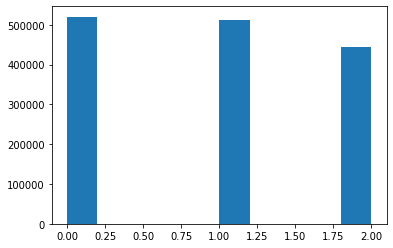

(316629, 44)


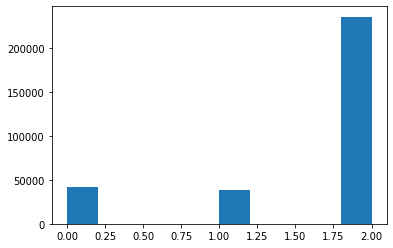

(316629, 44)


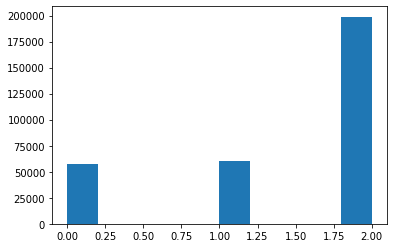

In [ ]:

#Hyperparameters
epochs = 30
lr = 0.00005
regularization = 0.5

    #input shape 
sequence_length = 50   #each sequence is composed by 5 day
batch_size = 64
num_features = 44

    #hidden shape
num_layer = 1
hidden_size = 64

#Create Sequences for the LSTM
def create_sequences(input_data, seq_len):
    sequences = []
    data_size = input_data.shape[0]
    Y = []
    print(input_data.shape)
    alpha = 0.0007226735755120588
    for i in range(data_size - 2*seq_len):
        sequence = input_data[i:i+seq_len, :]
        label_position = i + seq_len             #vede il valore della target column che abbiamo scelto come label dell'elemento successivo 
        ask_minus = sequence[:, :1]
        bid_minus = sequence[:, 2:3]
        ask_plus = input_data[(i+seq_len):(i+2*seq_len), :1]
        bid_plus = input_data[(i+seq_len):i+2*seq_len, 2:3]
        m_minus = (ask_minus + bid_minus) / 2
        m_minus = np.sum(m_minus) / seq_len
        m_plus = (ask_plus + bid_plus) / 2
        m_plus = np.sum(m_plus) / seq_len
        #print((m_plus - m_minus) / m_minus)
        if (m_plus - m_minus) / m_minus < -alpha:
          label = 1
        elif (m_plus - m_minus) / m_minus > alpha:
          label = 0
        else:
          label = 2          
        Y.append(label)
        sequences.append((sequence, label))
        
    plt.hist(Y)
    plt.show()
    return sequences

train_sequences = create_sequences(dec_train, sequence_length)
test_sequences = create_sequences(dec_test, sequence_length)
val_sequences = create_sequences(dec_val, sequence_length)

In [ ]:
#Create the Dataset
class Dataset(Dataset):
    def __init__(self, sequences):  #trans is a list of trans that we can apply, a classical is totensor
        self.sequences = sequences

    def __len__(self):    #return the len of the dataste
        return len(self.sequences)

    def __getitem__(self, idx):  #idx is the index of the image that we want to load
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.from_numpy(sequence).float(),
            label = label
        )
      

#Create the DataLoader
class PriceDataModule():
    def __init__(self, train_sequences, val_sequences, test_sequences, num_workers=1, batch_size = 8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.val_sequences = val_sequences
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):        
        self.train_dataset = Dataset(self.train_sequences)
        self.test_dataset = Dataset(self.test_sequences)
        self.val_dataset = Dataset(self.val_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=self.num_workers
        )

data_module = PriceDataModule(train_sequences, val_sequences, test_sequences, 2, batch_size)
data_module.setup()
train_dataloader = data_module.train_dataloader()
test_dataloader = data_module.test_dataloader()
val_dataloader = data_module.val_dataloader()

#Create the LSTM model
class myLSTM(nn.Module):
    def __init__(self, n_features, num_classes, dropout, n_hidden=128, n_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers, # Stack LSTMs
        dropout = dropout       #is a way to do regularization
    )
        self.classifier = nn.Linear(n_hidden, num_classes) #after we have analyze the sequence, now we have to perform the classification, we utilize a classic linear layer
        
    def forward(self, x):
        self.lstm.flatten_parameters()  
        #x shape is (batch_size, seq_len, n_features)

        output, (hidden, _) = self.lstm(x)
        out = hidden[-1]  #We want the output from the last layer of the last time step to go into the final regressor linear layer, we don't use output 
                          #because in the output there are the H_t for each time step from the last layer, so the dim is (batch_size, L, Hidden_size)
                          #instead in hidden there are hidden state for every layer but only for the last time step, so the dim is (num_layer, Hidden_size) 
                          #so if batch_size=1, the last array of output = hidden[-1]
      
        return self.classifier(out)

model = myLSTM(num_features, num_classes, regularization, hidden_size, num_layer).to(device)
model.float()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr)  

#Training the model
def trainingLoop(train_dataloader, model, loss_fn, optimizer):
    cont = 0
    train_loss = 0
    for batch in train_dataloader:         #scorriamo i vari batch del data set, in batch c'è l'index
        sequences = batch["sequence"].to(device)
        labels = batch["label"].to(device)
        #labels = labels.reshape(labels.shape[0], 1)
        outputs = model(sequences)            #facciamo la prediizone
        loss = loss_fn(outputs, labels)     #compute the error
        train_loss += loss
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cont+=1
        #if cont % random.randint(2000, 3000) == 0:
        #    loss = loss.item()
        #    print(loss)
    train_loss = train_loss / cont
    print()
    print(train_loss)

def testLoop(test_dataloader, model, loss_fn, test_size):
    true = [0, 0, 0]
    denom = [0, 0, 0, 0, 0, 0]
    num_batches = len(test_dataloader)
    test_loss = 0
    correct = 0

    with torch.no_grad():      #in questo modo gli stiamo dicendo utilizza il modello senza fare cambiamenti
        for batch in test_dataloader:         #scorriamo i vari batch del data set, in batch c'è l'index
            sequences = batch["sequence"].to(device)
            labels = batch["label"].to(device)
            #labels = labels.reshape(labels.shape[0], 1)
            outputs = model(sequences)            #facciamo la prediizone
            predicted = outputs.argmax(1)
            
            test_loss += loss_fn(outputs, labels).item()       #con .item() ci da il valore
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()     #contiamo quelli corretti
            
            for i in range(labels.size(dim=0)):   #compute the data to calculate precision and recall
              if (labels[i] == predicted[i] == 0):
                true[0] += 1
                denom[0] += 1
                denom[1] += 1
              elif (labels[i] == predicted[i] == 1):
                true[1] += 1
                denom[2] += 1
                denom[3] += 1
              elif (labels[i] == predicted[i] == 2):
                true[2] += 1
                denom[4] += 1
                denom[5] += 1
              elif (labels[i] == 0 and predicted[i] == 1):
                denom[1] += 1
                denom[2] += 1
              elif (labels[i] == 0 and predicted[i] == 2):
                denom[1] += 1
                denom[4] += 1
              elif (labels[i] == 1 and predicted[i] == 0):
                denom[3] += 1
                denom[0] += 1
              elif (labels[i] == 1 and predicted[i] == 2):
                denom[3] += 1
                denom[4] += 1
              elif (labels[i] == 2 and predicted[i] == 0):
                denom[5] += 1
                denom[0] += 1
              elif (labels[i] == 2 and predicted[i] == 1):
                denom[5] += 1
                denom[2] += 1

        test_loss = test_loss / num_batches        #average loss per batch
        correct = correct / test_size
        if (denom[1] != 0):
          recallUp = true[0] / denom[1]
        else:
          recallUp = 0

        if (denom[3] != 0):
          recallDown = true[1] / denom[3]
        else:
          recallDown = 0  

        if (denom[5] != 0):
          recallNo = true[2] / denom[5]
        else:
          recallNo = 0

        if (denom[0] != 0):
          precisionUp = true[0] / denom[0]
        else:
          precisionUp = 0

        if (denom[2] != 0):
          precisionDown = true[1] / denom[2]
        else:
          precisionDown = 0

        if (denom[4] != 0):
          precisionNo = true[2] / denom[4]
        else:
          precisionNo = 0

        print(f"Accuracy: {correct * 100}, Average loss: {test_loss}")
        print(f"Precision Up: {precisionUp * 100}, Recall Up: {recallUp* 100}, Precision Down: {precisionDown* 100}, Recall Down: {recallDown* 100}, Precision No: {precisionNo* 100}, Recall No: {recallNo* 100}")
    return test_loss



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("dropout   ->   " + str(regularization))
print("training range   ->   " + str(train_size))
print("number of layer   ->    " + str(num_layer))
print("sequence length    ->     " + str(sequence_length))
print("hidden size    ->    " + str(hidden_size))


best_test_loss = 99999
best_val_loss = 99999
for e in range(epochs):       #trainiamo il modello per 2 iterazioni
    print("------------Start of Epoch {}/{}------------".format(e, epochs-1))
    trainingLoop(train_dataloader, model, loss_fn, optimizer)
    val_loss = testLoop(val_dataloader, model, loss_fn, val_size)
    if (val_loss < best_test_loss): 
      torch.save(model, '/content/drive/MyDrive/Output/best_model_LSTM')
      best_test_loss = val_loss
      best_test_epoch = e
      print('model saved')      
    print("------------End of Epoch {}/{}------------".format(e, epochs-1))


------- List Hyper Parameters -------
epochs   ->   30
learningRate   ->   5e-05
dropout   ->   0.5
training range   ->   1477602
number of layer   ->    1
sequence length    ->     50
hidden size    ->    64
------------Start of Epoch 0/29------------

tensor(0.8966, grad_fn=<DivBackward0>)
Accuracy: 60.28917123826307, Average loss: 0.9223793795655432
Precision Up: 27.156963092299357, Recall Up: 15.783396028343976, Precision Down: 28.33476043334202, Recall Down: 12.575384564545711, Precision No: 67.95125755507895, Recall No: 87.63395708344439
model saved
------------End of Epoch 0/29------------
------------Start of Epoch 1/29------------

tensor(0.8491, grad_fn=<DivBackward0>)
Accuracy: 60.56646737980412, Average loss: 0.8842599069480466
Precision Up: 26.69111474395794, Recall Up: 10.569503980404164, Precision Down: 25.39517765299863, Recall Down: 17.784974307288138, Precision No: 69.56622003101268, Recall No: 87.9884938974408
model saved
------------End of Epoch 1/29------------
---

In [ ]:
model = torch.load('/content/drive/MyDrive/Output/best_model_LSTM')
testLoop(test_dataloader, model, loss_fn, test_size)
